<a href="https://colab.research.google.com/github/FrancisDcruz/OpenFairness/blob/commit1(18%2F12%2F2020)/payData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install aif360

     |████████████████████████████████| 174kB 11.8MB/s 


In [3]:
from scipy import stats
import random
from scipy.stats import boxcox
import pandas as pd 
from numpy import nan
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection

In [5]:
#from sklego.linear_model import DemographicParityClassifier
#from sklego.metrics import p_percent_score
from sklearn.model_selection import cross_val_score
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [8]:
from google.colab import files
files.upload()    

Saving Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv to Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv


{'Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv': b"Agency Name,EEO-4 Job Category,Pay Band,Employee Status,Race,Ethnicity,Gender,Number of Employees\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Black or African American,Non-Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Native Hawaiian or Pacific Islander,Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Unknown or Choose Not to Disclose,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispanic or Latino,Female,<5\nADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispa

In [9]:
data=pd.read_csv('/content/Local_Law_18_Pay_and_Demographics_Report_-_Agency_Report_Table.csv')

In [10]:
data.head()

,Agency Name,EEO-4 Job Category,Pay Band,Employee Status,Race,Ethnicity,Gender,Number of Employees
0,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Black or African American,Non-Hispanic or Latino,Female,<5
1,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Native Hawaiian or Pacific Islander,Hispanic or Latino,Female,<5
2,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Hispanic or Latino,Female,<5
3,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,Unknown or Choose Not to Disclose,Unknown or Choose Not to Disclose,Female,<5
4,ADMINISTRATION FOR CHILDREN'S SERVICES,ADMINISTRATIVE SUPPORT,30000-34999,Full-Time,White,Non-Hispanic or Latino,Female,<5


In [11]:
data['income']=''
for i in data.index:
  new=data['Pay Band'][i].split('-')
  my_list = np.array(new).astype(np.float)
  data['income'][i]=np.mean(my_list)

In [12]:
data['Income'] = np.where(data['income']>50000, 1, 0)
data=data.drop(columns=['income','Pay Band'])
for i in data.index:
  if data['Number of Employees'][i]=='<5':
    data['Number of Employees'][i]=random.randint(1,5)
fair_data=data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Distribution of Male and Female in the dataset

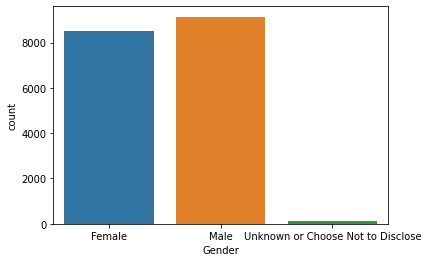

In [13]:
sns.countplot(data=data, x='Gender')

Distibution of Race categories with respect to gender.

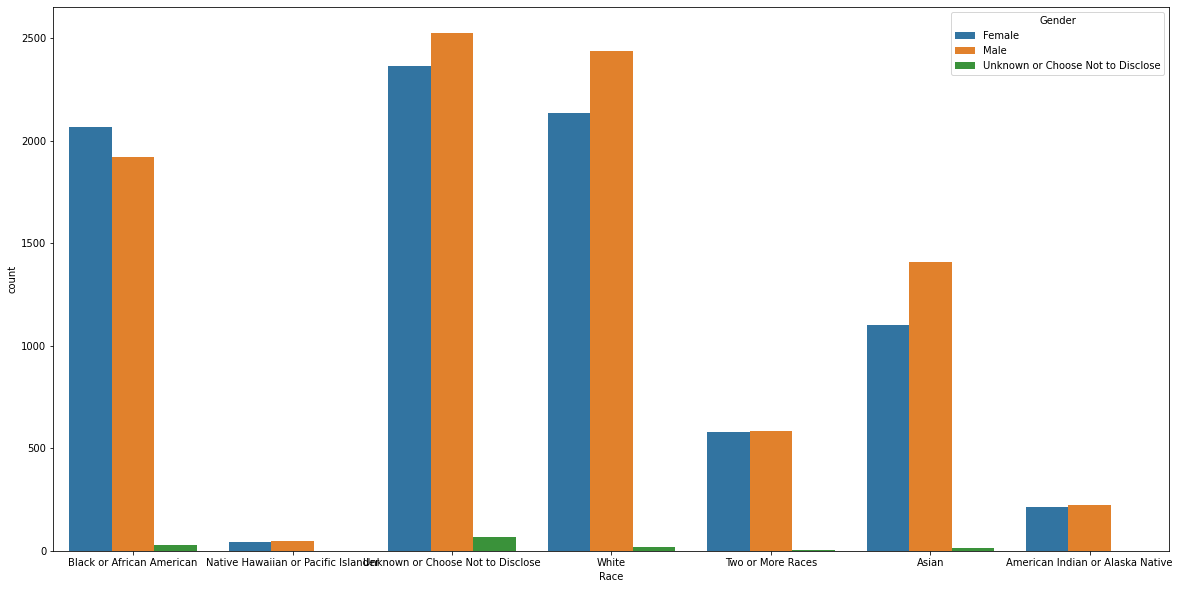

In [14]:
fig_dims = (20, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data=data,x='Race',hue='Gender',ax=ax,)

In [15]:
cols=['Agency Name', 'EEO-4 Job Category', 'Employee Status','Race', 'Ethnicity', 'Gender']
num_columns=['Number of Employees', 'Income']

In [16]:
data['Number of Employees'] = data['Number of Employees'].astype('int64')

In [17]:
data=pd.get_dummies(data, columns=cols)

In [18]:
df1 = data.pop('Income') # remove column b and store it in df1
data['Income']=df1 # add b series as a 'new' column.
data=data.drop(columns='Gender_Male')

In [19]:
def GetModelResult(X,Y):
  ratio=float(np.sum(Y==0)) / np.sum(Y==1)
  cols = ['Model', 'Accuracy', 'Precision','Recall']  
  Model_Result=pd.DataFrame(columns = cols) 
  models=[]
  models.append(('LR', LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2')))
  models.append(('LDA', LinearDiscriminantAnalysis()))
  models.append(('KNN', KNeighborsClassifier(n_neighbors = 19, metric = 'minkowski', p = 1,leaf_size=3)))
  models.append(('CART', DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))
  models.append(('NB', GaussianNB()))
  models.append(('SVM', SVC(kernel='linear', random_state= 0)))
  models.append(('RF',RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)))
  models.append(('XGB', XGBClassifier(scale_pos_weight=ratio)))
  # evaluate each model in turn
   
  scoring = ['accuracy','precision','recall']
  for name, model in models:
    df_result=[]
    results = []
    kfold = model_selection.KFold(n_splits=10)
    results.append(name)
    for score in scoring:
      cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=score)
      #print("%s: %f (%f)" % (score, cv_results.mean(), cv_results.std()))
      results.append(cv_results.mean())
    zipped=zip(cols,results)  
    df_result.append(dict(zipped))
    Model_Result=Model_Result.append(df_result,True)
  print(Model_Result)
  #Visualizing the results:
  fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
  fig.suptitle('Algorithm Comparison')
  custom_ylim = (0.5, 1)
  Model_Result.plot(kind='bar', x='Model',y='Accuracy',ax=ax[0],ylim=custom_ylim)
  Model_Result.plot(kind='bar', x='Model',y='Precision',ax=ax[1],ylim=custom_ylim)
  Model_Result.plot(kind='bar', x='Model',y='Recall',ax=ax[2],ylim=custom_ylim)
  

def score(y_test,y_pred):
  print(pd.crosstab(
    pd.Series(y_test,name='Actual'),
    pd.Series(y_pred,name='Predicted'),
    margins=True
  ))
  print('Accuracy:{0:.2f}'.format(accuracy_score(y_test,y_pred)))
  print('Precision:{0:.2f}'.format(precision_score(y_test,y_pred)))
  print('Recall:{0:.2f}'.format(recall_score(y_test,y_pred)))

def ROC(model,y_test,probs):
  fpr, tpr, thresholds = roc_curve(y_test, probs[:,1])
  plt.title('ROC CURVE')
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.plot(fpr, tpr)
  plt.show()
  
  

def cvscore(model,x_train,y_train):
  scores = cross_val_score(model, x_train, y_train, cv=5)
  print(" CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [20]:
cols=data.columns
x=data.iloc[:,:-1].values
y=data.iloc[:,-1].values

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x,y, test_size=0.30,random_state=0)

In [22]:
train=np.concatenate((x_train,y_train.reshape(-1,1)),axis=1)
test=np.concatenate((x_test,y_test.reshape(-1,1)),axis=1)
train=pd.DataFrame(train,columns=cols)
test=pd.DataFrame(test,columns=cols)

In [23]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection

In [24]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x_train= sc.fit_transform(x_train)
x_test= sc.fit_transform(x_test)

  Model  Accuracy  Precision    Recall
0    LR  0.823940   0.825344  0.954882
1   LDA  0.825709   0.816601  0.974091
2   KNN  0.811157   0.800558  0.978642
3  CART  0.763889   0.843665  0.820663
4    NB  0.810915   0.801097  0.976925
5   SVM  0.814775   0.809246  0.968196
6    RF  0.779806   0.837876  0.856760
7   XGB  0.755528   0.928801  0.711429


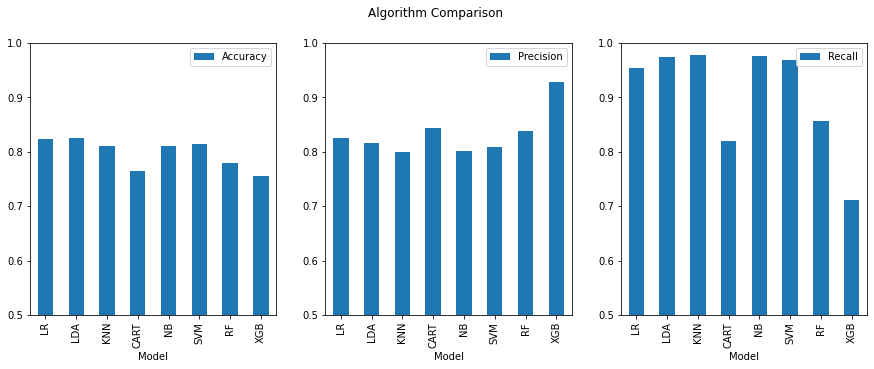

In [25]:
GetModelResult(x_train,y_train)

From the above figure, Since Logistic Regression and LDA have a very close accuracy we consider Logistic Regression. for further analysis

# **Predictions before performing fairness transformation**


Predicted    0     1   All
Actual                    
0          751   838  1589
1          192  3551  3743
All        943  4389  5332
Accuracy:0.81
Precision:0.81
Recall:0.95


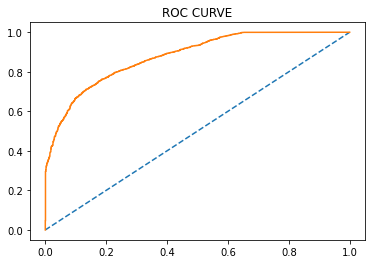

In [26]:
model=LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2').fit(x_train,y_train)
y_pred=model.predict(x_test)
fair_pred=model.predict(x_train)
probs = model.predict_proba(x_test)
score(y_test,y_pred)
ROC(model,y_test,probs)

The above graph is showing the performance of a classification model at all classification thresholds.

# Fairness Model Implementation 

We use the similar data which we used for training the models above i.e x_train ,and will use x_test to check the results of our fair model

In [27]:
#creating dataset fair_data with the original dependent variable and creating pred_data with the predected dependent variable from the above logistic Regression model.
fair_data=train
x=train.iloc[:,:-1].values
pred_data=np.concatenate((x,fair_pred.reshape(-1,1)),axis=1)
pred_data=pd.DataFrame(pred_data,columns=cols)
#fair_data=fair_data.drop(columns='Gender_Male')
#pred_data=pred_data.drop(columns='Gender_Male')

In [28]:
#Transforming the pandas dataframe into BinaryLabelDataset format.
train_pp_bld = BinaryLabelDataset(df=fair_data,
                                  label_names=['Income'],
                                  protected_attribute_names=['Gender_Female'],
                                  favorable_label=1,
                                  unfavorable_label=0)
pred_pp_bld = BinaryLabelDataset(df=pred_data,
                                  label_names=['Income'],
                                  protected_attribute_names=['Gender_Female'],
                                  favorable_label=1,
                                  unfavorable_label=0)

privileged_groups = [{'Gender_Female':0}] 
unprivileged_groups = [{'Gender_Female': 1}]

cc=class_train_bld=ClassificationMetric(train_pp_bld,pred_pp_bld,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [32]:
import plotly.graph_objects as go

fairness_metrics = ['statistical_parity','Average_Odds','Equal_Opportunity']

fig = go.Figure()
fig.add_trace(go.Bar(x=fairness_metrics, y=[cc.statistical_parity_difference(),cc.average_odds_difference(),cc.equal_opportunity_difference()],
                base=0,
                marker_color='Blue',
                name='Before_Bias_mitigation'))
fig.show()

Predicted  0.0   1.0   All
Actual                    
0          751   838  1589
1          192  3551  3743
All        943  4389  5332
Accuracy:0.81
Precision:0.81
Recall:0.95


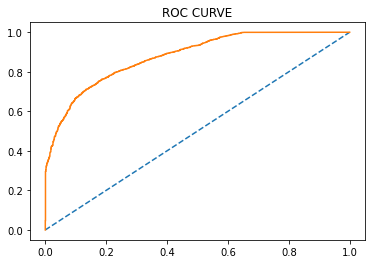

In [33]:
model=LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2').fit(sc.fit_transform(train_pp_bld.features),train_pp_bld.labels.ravel())
fair_ypred=model.predict(x_test)
score(y_test,fair_ypred)
ROC(model,y_test,model.predict_proba(x_test))

**Statistical Parity Difference**
*   The ideal value of this metric is 0
*   Fairness for this metric is between -0.1 and 0.1

**Equal Opportunity Difference**


 

*   The ideal value is 0. 
*   Fairness for this metric is between -0.1 and 0.1




**Average Odds Difference**
*   The ideal value is 0.
*   Fairness for this metric is between -0.1 and 0.1



In [34]:
rw = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
rw_data = rw.fit_transform(train_pp_bld)

Predicted  0.0   1.0   All
Actual                    
0          747   842  1589
1          189  3554  3743
All        936  4396  5332
Accuracy:0.81
Precision:0.81
Recall:0.95


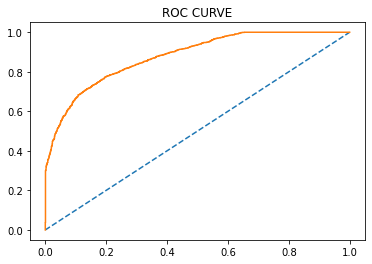

In [36]:
model=LogisticRegression(random_state=0,max_iter=1000,C=0.01,penalty='l2').fit(sc.fit_transform(rw_data.features),rw_data.labels.ravel(),sample_weight=rw_data.instance_weights)
fair_ypred=model.predict(x_test)
train_pred=model.predict(sc.fit_transform(rw_data.features))
score(y_test,fair_ypred)
ROC(model,y_test,model.predict_proba(x_test))

In [37]:
pred_rw_data=rw_data.copy()
pred_rw_data.labels=train_pred.reshape(-1,1)
cr=class_train_bld=ClassificationMetric(rw_data,pred_rw_data,
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

In [38]:
import plotly.graph_objects as go

fairness_metrics = ['statistical_parity','Average_Odds','Equal_Opportunity']

fig = go.Figure()
fig.add_trace(go.Bar(x=fairness_metrics, y=[cc.statistical_parity_difference(),cc.average_odds_difference(),cc.equal_opportunity_difference()],
                base=0,
                marker_color='Blue',
                name='Before_Bias_mitigation'))
fig.add_trace(go.Bar(x=fairness_metrics, y=[cr.statistical_parity_difference(),cr.average_odds_difference(),cr.equal_opportunity_difference()], 
                base=0,
                marker_color='lightslategrey',
                name='After_Bias_mitigation'
                ))
fig.show()